# Predicting Turbofan Engine Remaining Useful Life: An ML Approach

### 0.0 Problem Introduction and Objective

The US Department of Defense has selected De Alwis ML Consulting Group to build it's predictive maintenance application, which is one of the DoD's National Mission Initiatives (NMIs). The goal is to build an application that can accurately predict turbofan engine failure. 

The DoD has listed some of its outcome goals for De Alwis ML Consulting Group:
- reduce costs
- enhance inventory managment and cash-flow managment
- enhance mission readiness 
- save lives by reducing engine failure during high risk missions with life-threatenting consequences
- disaster prevention

**Prediction Goals**

- Predict the probability a turbofan engine is likely to fail in its current state
- Predict the remaining useful life (RUL) of each engine. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

Hence we will need to build two models: a classifier with priobability score and a regression model to predict RUL. 

**De Alwis ML Consulting Group deliverables**

- a front end web appliaction that allows the DoD to simulate and monitor turbofan engine failure predictions
- a detailed summary of work including an executive summary of findings, reproducible data pipeline, extensive exploratory analysis, modelling assumptions, training and test set performance metrics.



### 0.1 Datasets

Kaggle description of the dataset is below:

<div class="alert alert-info" role="alert">
    
Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 
    
</div>

The training set data contains a number of engines being run simultaneously until it fails. While the experiments were conducted till failure, all data till failure are not made public. Instead, data for an arbitrary number of cycles are provided for each engine of the test set. The task is then to predict after how many cycles each engine will fail. This predicted value is our remaining useful life (RUL). 

The training data does not contain the RUL values, but we can calculate them from the training data itself as it contains the run to failure data for each engine. Our assumption for training set RUL will use *linear-degredation*. 

### 0.3 Data Lineage

Data lineage plays an important role in a machine learning workflow as it tracks data/meta data movements throughout your ML pipelines. Metadata is the “data about the data”, which includes various information about the data assets, such as the type, format, structure, author, date created, date modified and file size. 

Our data lineage path so far is as follows (will continue to track):
- download data from NASA/Kaggle into 'raw' data folder in project scaffolding 
- push data to 'processed' folder after data pre-processing pipeline is applied (feature engineering, feature selection, etc.)


### 1.0 Exploratory Data Analysis (EDA)

Although there are four training and test set pairs, we will consider only FD001 for our exploratory analysis. However, we will make predictions against all four test sets at the modelling stage. In FD001, there are 100 turbofan engines (unit numbers) with 21 sensors and 3 settings. We assume each row in the dataset is a a snapshot in time during a cycle for the given engine. 

#### 1.1 Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns

# function to load any of the four training/test set pairs

def load_data(fleet: int):
    
    """
    Function that allows for creation of training/test set pairs for each of the four datasets provided. 
    
    Arguments: 
        fleet (int): 1,2,3 or 4 corresponding to the data sets FD001, FD002, FD003 and FD004, respectively 
    
    Returns: 
        pandas dataframes for each training and test set pair along with the RUL test set for each fleet
    """    
    
    valid_fleets = [1,2,3,4]
    
    if not valid_fleets:
        print("The only valid fleet numbers are 1,2,3,4")
    
    if fleet == 1: 
        index_names = ['unit_number', 'time_cycles']
        setting_names = ['setting_1', 'setting_2', 'setting_3']
        sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
        col_names = index_names + setting_names + sensor_names

        train_string = 'train_FD00' + str(fleet) + '.txt'
        test_string = 'test_FD00' + str(fleet) + '.txt'
        RUL_string = 'RUL_FD00' + str(fleet) + '.txt'
        
        train = pd.read_csv(train_string,sep='\s+',header=None,index_col=False,names=col_names)
        test = pd.read_csv(test_string,sep='\s+',header=None,index_col=False,names=col_names)
        y_test = pd.read_csv(RUL_string,sep='\s+',header=None,index_col=False,names=['RUL'])
        
    
    # add other fleets later
    if fleet == 2:
        None
    if fleet == 3:
        None
    if fleet == 4:
        None
    
    return train, test, y_test  

In [2]:
# load data for FD001
train = load_data(1)[0]
test = load_data(1)[1]
rul = load_data(1)[2]

#### 1.2 Explore data types, dimensions and missing values

In [3]:
# a peak at the training data
train.sample(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
19434,95,166,0.0052,0.0001,100.0,518.67,642.74,1588.49,1399.51,14.62,...,521.51,2387.96,8155.09,8.4175,0.03,393,2388,100.0,39.06,23.4982
7790,40,153,0.0019,-0.0004,100.0,518.67,643.23,1594.83,1416.22,14.62,...,520.94,2388.15,8161.16,8.5221,0.03,396,2388,100.0,38.56,23.1506
17267,85,116,0.0004,0.0000,100.0,518.67,642.49,1594.11,1406.09,14.62,...,520.79,2388.10,8125.78,8.4657,0.03,394,2388,100.0,38.66,23.2875
2916,15,28,-0.0028,0.0000,100.0,518.67,641.91,1589.80,1392.82,14.62,...,523.05,2387.99,8141.19,8.3697,0.03,391,2388,100.0,39.11,23.4034
12655,64,175,0.0020,-0.0005,100.0,518.67,642.73,1600.13,1408.59,14.62,...,521.16,2388.11,8145.85,8.4355,0.03,394,2388,100.0,38.76,23.2703


In [4]:
# training, test dimensions
print(f"training set: {train.shape}, test shape: {test.shape}")

training set: (20631, 26), test shape: (13096, 26)


In [5]:
# unique engines
print(f"There are {len(train['unit_number'].unique())} unique engines in the training data, \
{len(test['unit_number'].unique())} in the test data and \
{len(rul)} in the RUL test data")


There are 100 unique engines in the training data, 100 in the test data and 100 in the RUL test data


In [6]:
# data types
train.dtypes

unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
s_1            float64
s_2            float64
s_3            float64
s_4            float64
s_5            float64
s_6            float64
s_7            float64
s_8            float64
s_9            float64
s_10           float64
s_11           float64
s_12           float64
s_13           float64
s_14           float64
s_15           float64
s_16           float64
s_17             int64
s_18             int64
s_19           float64
s_20           float64
s_21           float64
dtype: object

In [7]:
# cycles for each engine
print("Training set number of cycles for each engine:")
print("\n")
print(train.groupby('unit_number')['time_cycles'].count().values)
print("\n")
print("Test set number of cycles for each engine:")
print("\n")
print(test.groupby('unit_number')['time_cycles'].count().values)
print("\n")
print("True RUL number of cycles for each engine in test set:")
print("\n")
print(rul['RUL'].values)

Training set number of cycles for each engine:


[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]


Test set number of cycles for each engine:


[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


True RUL number of cycles for each engine in test set:


[112  98  69  82  91  93  91  9

#### Missing value check

- our datasets contain no missing values, we won't need to worry about that in our pre-processing pipeline

In [8]:
# training
train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

In [9]:
test.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

In [10]:
# target test
rul.isna().sum()

RUL    0
dtype: int64

#### 1.3 Summary and descriptive statistics

- the settings features have very low variance, we will likely not need them for modelling with target (RUL)
- a number of sensors also have very low variance, we will need to look into these further to determine if we keep them in the feature selection stage of our pre-processing pipeline

In [11]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


#### 1.4 Data distributions

#### 1.4.1 Boxplot 

- sensors 1,5,6,10,16,18 and 19 are constants and will not be useful for modelling
- some sensors (e.g. 3,8,9,14) have quite of few outliers that we may need to deal with during pre-processing

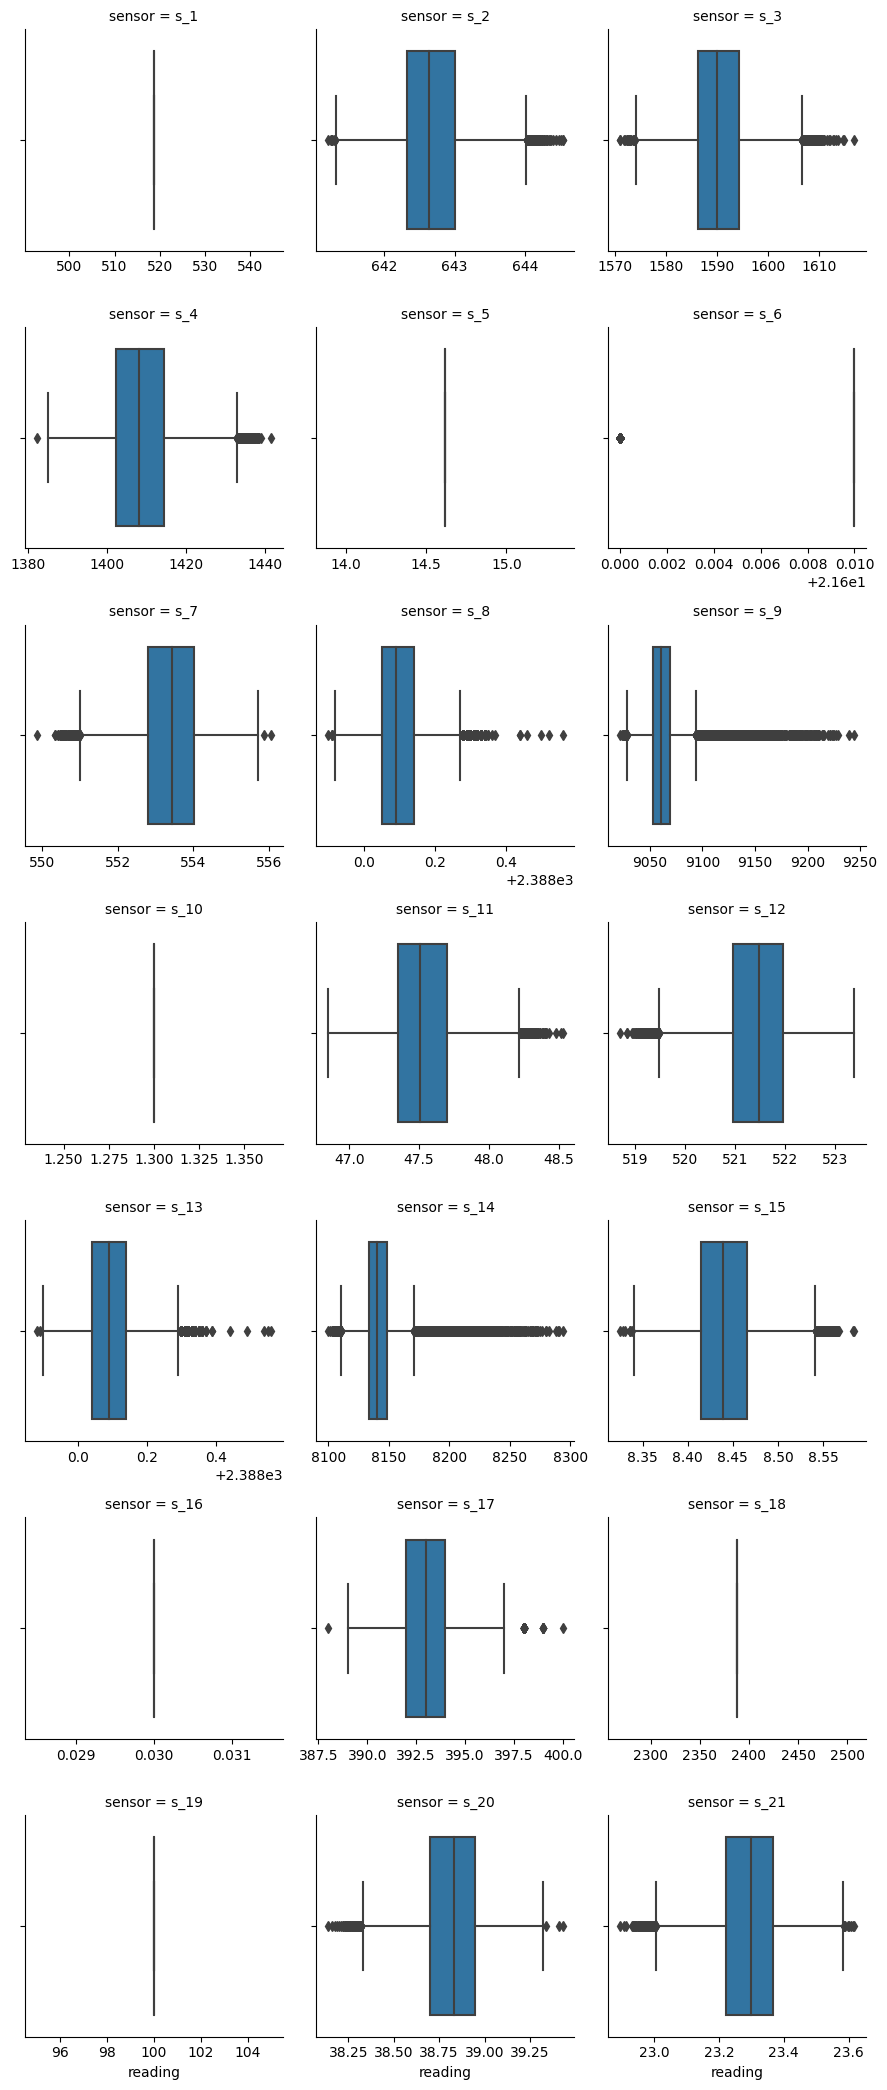

In [12]:
import matplotlib.pyplot as plt

# melt down the dataframe to use with FacetGrid for box-plots
sensor_cols = train.iloc[:, np.r_[0, 5:26]]

melted = pd.melt(sensor_cols, id_vars=['unit_number'], value_vars=sensor_cols.iloc[:,1:22], \
       var_name='sensor', value_name='reading')

t = melted[['sensor','reading']]
g = sns.FacetGrid(t, col="sensor", col_wrap=3, sharex=False)
g.map_dataframe(sns.boxplot, "reading");


#### 1.4.2 Histograms

- some sensors appear to have approximately Guassian distributions but others are skewed or multi-modal
- likely will need a scaling solution and possibly a transformation to bring skewed distributions to more Guassian

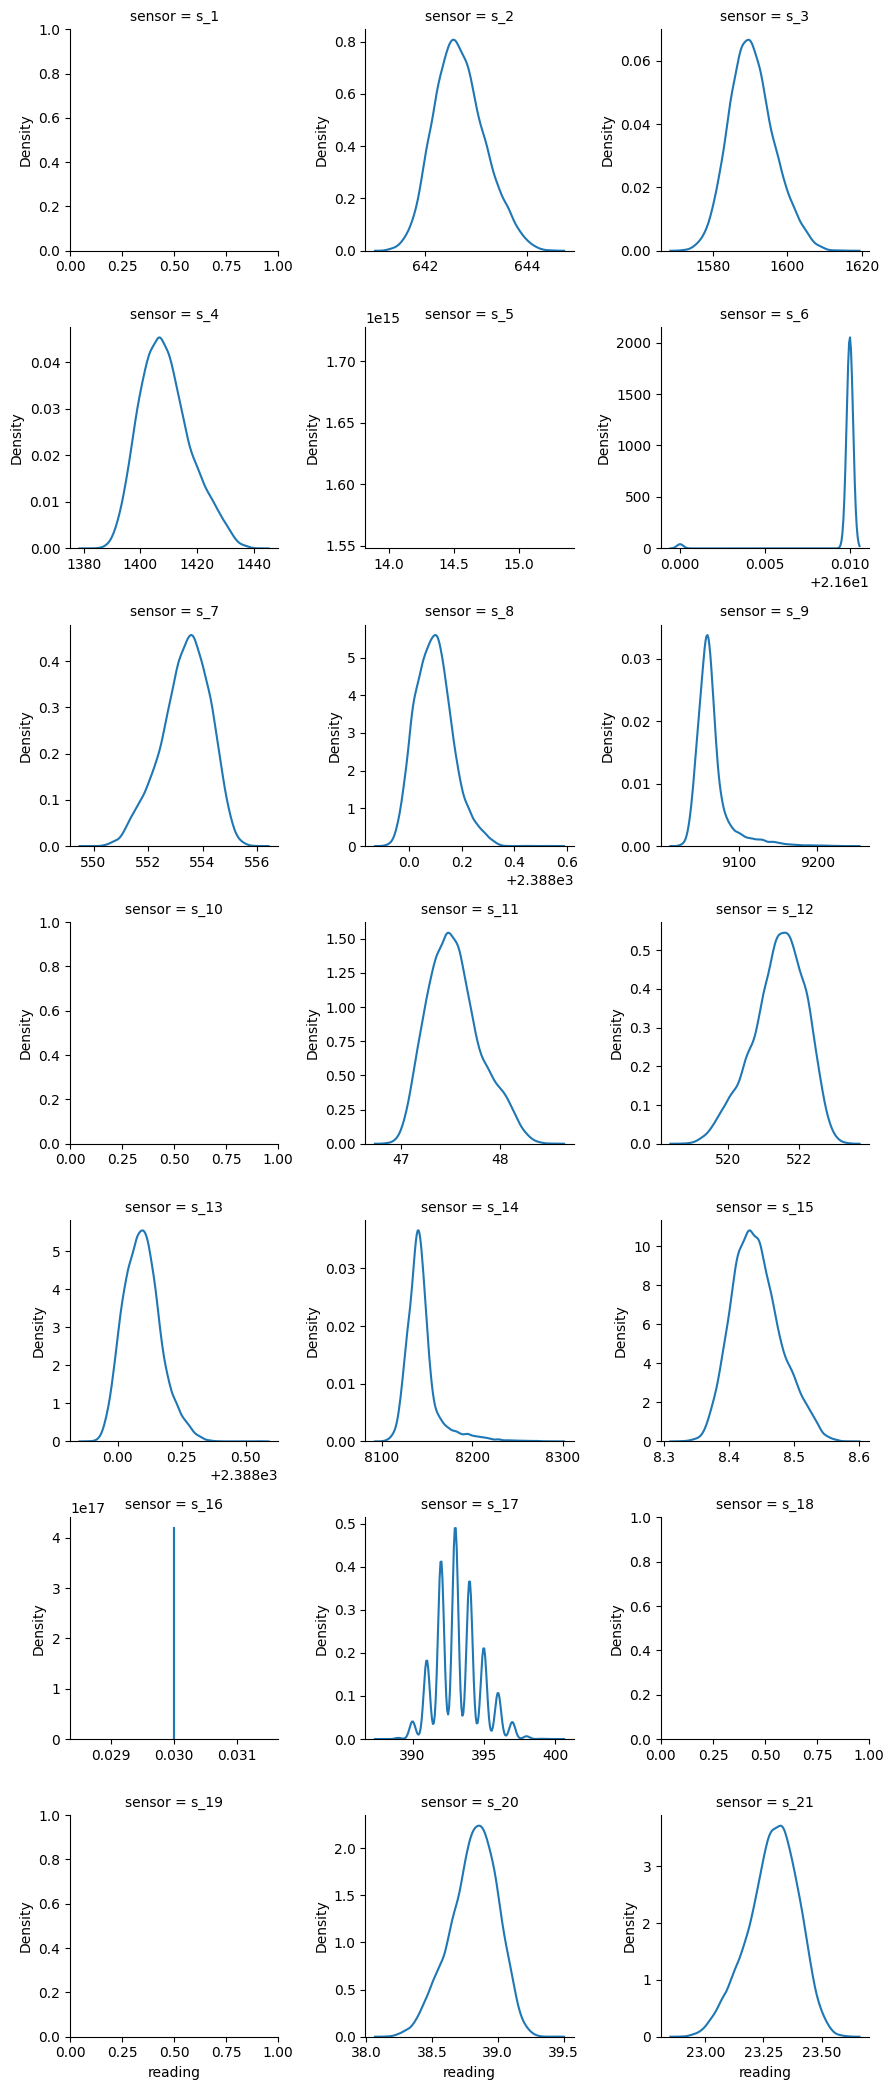

In [13]:
g = sns.FacetGrid(t, col="sensor", col_wrap=3, sharey=False, sharex=False)
g.map_dataframe(sns.kdeplot, "reading");

Let's now calculate our target feature (RUL) in our training data. 

In [14]:
# function to create Remaining Useful life column in training data
def rul_func(df):    
    return df.groupby('unit_number')['time_cycles'].max()

temp = pd.DataFrame(rul_func(train)).reset_index()
train = train.merge(temp, left_on='unit_number', right_on='unit_number')  
train['RUL']=train['time_cycles_y']-train['time_cycles_x']

In [15]:
# max cycles
train.groupby('unit_number').max().reset_index().head(5)

,unit_number,time_cycles_x,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,time_cycles_y,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,192,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,287,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,179,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,189,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,269,268


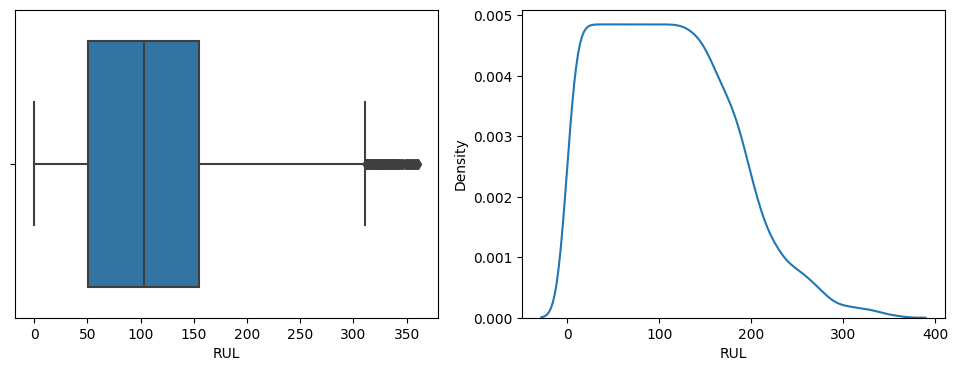

In [16]:
# distribution of RUL in training data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='RUL', data=train, ax=ax[0])
sns.kdeplot(x='RUL', data=train, ax=ax[1]);

#### 1.5 Correlation Analysis

- RUL is highly positively correlated with a number of sensors (2,3,4,8,13,15,17) and lightly negatively correlated with the others
- Many sensors are strongly correlated with each other (both positively and negatively). We may need to address this by reducing the features

In [78]:
train_corr = train.iloc[:, np.r_[27,6:9,11:14,16:22,25:26]].corr()
train_corr

,RUL,s_2,s_3,s_4,s_7,s_8,s_9,s_12,s_13,s_14,s_15,s_16,s_17,s_21
RUL,1.000000,-0.606484,-0.584520,-0.678948,0.657223,-0.563968,-0.390102,0.671983,-0.562569,-0.306769,-0.642667,NaN,-0.606154,0.635662
s_2,-0.606484,1.000000,0.602610,0.714949,-0.702136,0.662325,0.273764,-0.724578,0.661792,0.179752,0.675975,NaN,0.629886,-0.668050
s_3,-0.584520,0.602610,1.000000,0.678413,-0.664595,0.602481,0.322964,-0.680307,0.600963,0.237137,0.639921,NaN,0.600017,-0.633901
s_4,-0.678948,0.714949,0.678413,1.000000,-0.793130,0.746852,0.297429,-0.815591,0.745158,0.190748,0.758459,NaN,0.703499,-0.745193
s_7,0.657223,-0.702136,-0.664595,-0.793130,1.000000,-0.767132,-0.217835,0.812713,-0.764611,-0.110053,-0.747051,NaN,-0.692893,0.737447
s_8,-0.563968,0.662325,0.602481,0.746852,-0.767132,1.000000,-0.032091,-0.786540,0.826084,-0.144787,0.700949,NaN,0.627785,-0.688840
s_9,-0.390102,0.273764,0.322964,0.297429,-0.217835,-0.032091,1.000000,-0.210238,-0.034763,0.963157,0.293753,NaN,0.337110,-0.292795
s_12,0.671983,-0.724578,-0.680307,-0.815591,0.812713,-0.786540,-0.210238,1.000000,-0.788441,-0.098141,-0.766052,NaN,-0.703485,0.756263
s_13,-0.562569,0.661792,0.600963,0.745158,-0.764611,0.826084,-0.034763,-0.788441,1.000000,-0.147036,0.697662,NaN,0.627410,-0.688948
s_14,-0.306769,0.179752,0.237137,0.190748,-0.110053,-0.144787,0.963157,-0.098141,-0.147036,1.000000,0.193761,NaN,0.246621,-0.192415


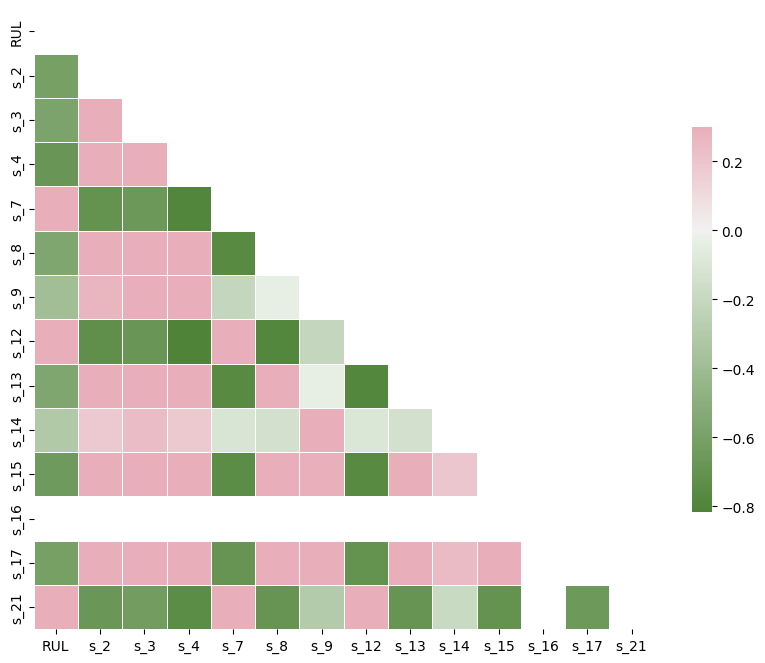

In [84]:
# heatmap
mask = np.triu(np.ones_like(train_corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(120, 5, as_cmap=True)
sns.heatmap(train_corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5});